# ELEC0134 - Applied Machine Learning Systems Assignment 22-23
## A1: Gender Detection

This notebook will create a SVM model to detect gender on the celeba dataset. To create the model the following steps will be followed:

1. Image preprocessing to extract facial landmarks.
2. Normalization of the features.
3. Training the SVM model 
4. Tuning hyperparameters of SVM model 

## 1) Preprocessing
### Facial landmark extraction



In [1]:
# Imports 

import os.path
import numpy as np
from keras.preprocessing import image
import cv2
import dlib
import imutils
from imutils import face_utils

2023-01-20 14:36:42.046726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 14:36:42.190278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /lib64:/lib:/usr/local/lib:/usr/local/lib64:/usr/lib64:/usr/lib:/apps/cuda/lib64:/apps/cuda/lib
2023-01-20 14:36:42.190307: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 14:36:46.766789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dy

ImportError: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/_dlib_pybind11.cpython-38-x86_64-linux-gnu.so)

Uses dlib library's pretrained shape predictor to predict the locations of 668 landmarks on detected faces. 

In [ ]:
detector = dlib.get_frontal_face_detector()

# Uses landmark predictor from parent directory
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

In [ ]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [ ]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [ ]:
def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

In [12]:
def extract_features_labels(images_dir, labels_dir, name):
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
    It also extracts the gender label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        gender_labels:      an array containing the gender label (male=0 and female=1) for each image in
                            which a face was detected
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(labels_dir, 'r')
    print('labels_file ', labels_file)
    lines = labels_file.readlines()
    gender_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]}
    counter = 0
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        fails = []

        for img_path in image_paths:
            file_name= img_path.split('.')[0].split('/')[-1]

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(gender_labels[file_name])
            else: 
                fails.append(file_name)
            counter += 1
            print(counter)


    landmark_features = np.array(all_features)
    landmark_features = landmark_features.reshape(len(landmark_features), 136)
    gender_labels = np.array(all_labels)

    np.save("all_features_{}.npy".format(name), landmark_features)
    np.save("gender_labels_{}.npy".format(name), gender_labels)

    return landmark_features, gender_labels, fails


In [2]:
train_img = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23/celeba/img'
train_label = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23/celeba/labels.csv'
extract_features_labels(train_img, train_label, 'train')

test_img = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23_test/celeba_test/img'
test_label = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23_test/celeba_test/labels.csv'
extract_features_labels(test_img, test_label, 'test')


NameError: name 'extract_features_labels' is not defined

In [3]:
# Loading in training and test data from npy files
features_train = np.load('all_features_train.npy')
labels_train = np.load('gender_labels_train.npy')

features_test = np.load('all_features_test.npy')
labels_test = np.load('gender_labels_test.npy')


In [4]:
print('features_train: ', features_train.shape)
print('features_test: ', features_test.shape)
print('labels_train: ', labels_train.shape)
print('labels_test: ', labels_test.shape)

features_train:  (4798, 136)
features_test:  (970, 136)
labels_train:  (4798,)
labels_test:  (970,)


Standardize data function

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
def preprocessing(features, test_features):
    
    # Scaling of data, trained on training data and applied to both training and test datasets
    scaler = StandardScaler()
    scaler.fit(features)

    features = scaler.transform(features)
    test_features = scaler.transform(test_features)
    
    return features, test_features

In [13]:
features_train, features_test = preprocessing(features_train, features_test)

In [14]:
print(features_train)

[[ 1.40032108 -0.03334686  1.23478692 ...  1.40073399 -1.58560512
   1.10677476]
 [ 0.98662464 -0.67163776  0.90481657 ...  1.40073399 -1.58560512
   1.10677476]
 [-0.15104059 -2.37374681 -0.08509448 ...  0.90721647  0.1631651
   1.10677476]
 ...
 [ 0.26265586  0.3921804   0.4648561  ...  0.16694017 -0.12829661
   0.07774554]
 [ 1.50374519  0.60494403  1.45476715 ... -1.06685365 -1.00268172
  -1.20854099]
 [ 0.6763523  -0.45887413  0.68483634 ...  0.16694017 -0.71122001
   0.07774554]]


Checking features to decide ranges of hyperparameters to check for tuning

In [15]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


In [48]:
def hyperparam_determine(features, labels, parameters):
    rnd_search = RandomizedSearchCV(SVC(), param_distributions = parameters, n_iter = 10, refit = True, verbose = 3, cv = 10, n_jobs = 5)
    rnd_search.fit(features, labels)
    print("Optimal params: ", rnd_search.best_params_)
    return rnd_search.best_params_

In [49]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV


In [50]:
linear_parameters = {'C': np.logspace(-2, 2, num = 20),
                    'kernel': ['linear'],
                    }

poly_parameters = {'C': np.logspace(-2, 2, num = 20),
                    'kernel': ['poly'],
                    'degree': [2,3,4,5,6],
                    'coef0': np.logspace(-1, 2, num = 5)
                    }

rbf_parameters = {'C': np.logspace(-2, 2, num = 20),
                    'kernel': ['rbf'],
                    'gamma': np.logspace(-3, 3, num = 6)
                    }


In [51]:
#print("-_-_-_-_-_- Linear -_-_-_-_-_-")
#hyperparam_determine(features_train, labels_train, linear_parameters)
#print("-_-_-_-_-_- Poly -_-_-_-_-_-")
#hyperparam_determine(features_train, labels_train, poly_parameters)
#print("-_-_-_-_-_- RBF -_-_-_-_-_-")
#hyperparam_determine(features_train, labels_train, rbf_parameters)

-_-_-_-_-_- Linear -_-_-_-_-_-
Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [52]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# create a dictionary containing the optimal hyperparameters
optimal_linear_params = {'C': 1.0974987654930568}

# Create an instance of LinearSVC
linear_svm = LinearSVC(**optimal_linear_params)

# Fit the model to the training data
linear_svm.fit(features_train, labels_train)

# Make predictions on the test data
y_pred_linear = linear_svm.predict(features_test)

# Evaluate the model's performance using different metrics
acc = accuracy_score(labels_test, y_pred_linear)
prec = precision_score(labels_test, y_pred_linear)
recall = recall_score(labels_test, y_pred_linear)
f1 = f1_score(labels_test, y_pred_linear)

print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')


Accuracy: 0.925
Precision: 0.945
Recall: 0.900
F1-score: 0.922


/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a dictionary containing the optimal hyperparameters
optimal_poly_params = {'C': 2.412585708945664, 'coef0': 1.46514376691162, 'degree': 3.812601682766892, 'kernel': 'poly'}

# Create an instance of SVM with polynomial kernel and the optimal hyperparameters
poly_svm = SVC(**optimal_poly_params)

# Fit the model to the training data
poly_svm.fit(features_train, labels_train)

# Make predictions on the test data
y_pred_poly = poly_svm.predict(features_test)

# Evaluate the model's performance using different metrics
acc = accuracy_score(labels_test, y_pred_poly)
prec = precision_score(labels_test, y_pred_poly)
recall = recall_score(labels_test, y_pred_poly)
f1 = f1_score(labels_test, y_pred_poly)

print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')


Accuracy: 0.923
Precision: 0.936
Recall: 0.906
F1-score: 0.921


In [53]:
# Create a dictionary containing the optimal hyperparameters
optimal_rbf_params = {'C': 6.168511362971495, 'gamma':  0.001911367049223174, 'kernel': 'rbf'}

# Create an instance of SVM with polynomial kernel and the optimal hyperparameters
rbf_svm = SVC(**optimal_rbf_params)

# Fit the model to the training data
rbf_svm.fit(features_train, labels_train)

# Make predictions on the test data
y_pred_rbf = rbf_svm.predict(features_test)

# Evaluate the model's performance using different metrics
acc = accuracy_score(labels_test, y_pred_rbf)
prec = precision_score(labels_test, y_pred_rbf)
recall = recall_score(labels_test, y_pred_rbf)
f1 = f1_score(labels_test, y_pred_rbf)

print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

Accuracy: 0.923
Precision: 0.938
Recall: 0.904
F1-score: 0.921


In [54]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

In [55]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None):


    axes[0].set_title(title)

    axes[0].set_xlabel("Training examples")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs = -1, \
                       train_sizes = np.linspace(.1, 1.0, 5),
                       return_times = True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    axes[0].set_ylabel("Accuracy Score")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit times (s)")
    axes[1].set_title("Scalability of the model")
    return plt

<module 'matplotlib.pyplot' from '/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/matplotlib/pyplot.py'>

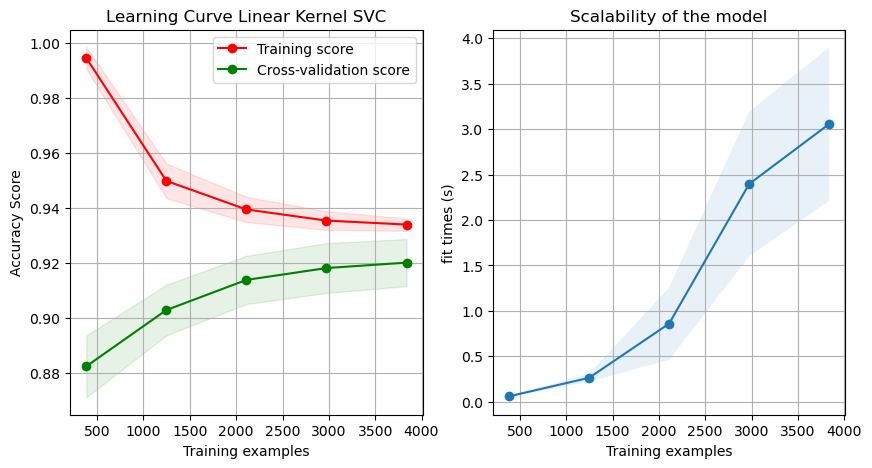

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot learning curve for polynomial kernel SVC
title = "Learning Curve Linear Kernel SVC"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(linear_svm, title, features_train, labels_train, axes=axes, 
                    ylim=(0.7, 1.01), cv = cv)

<module 'matplotlib.pyplot' from '/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/matplotlib/pyplot.py'>

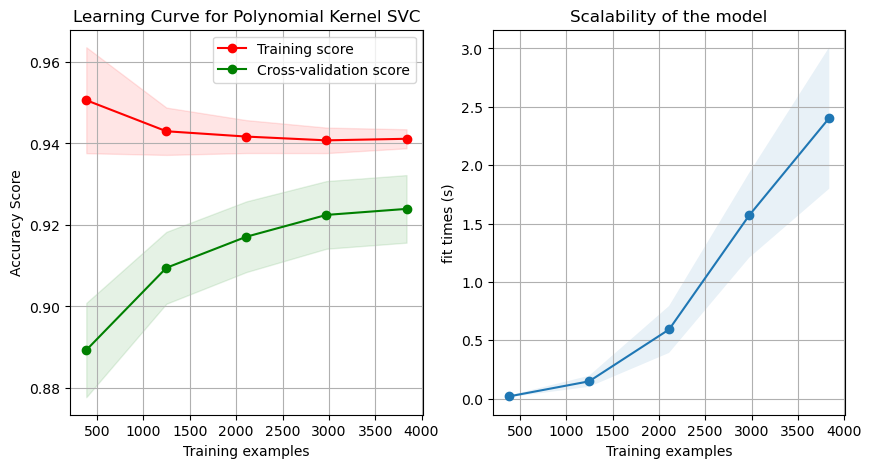

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

title = "Learning Curve for Polynomial Kernel SVC"

plot_learning_curve(poly_svm, title, features_train, labels_train, axes=axes, 
                    ylim=(0.7, 1.01), cv = cv)

<module 'matplotlib.pyplot' from '/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/matplotlib/pyplot.py'>

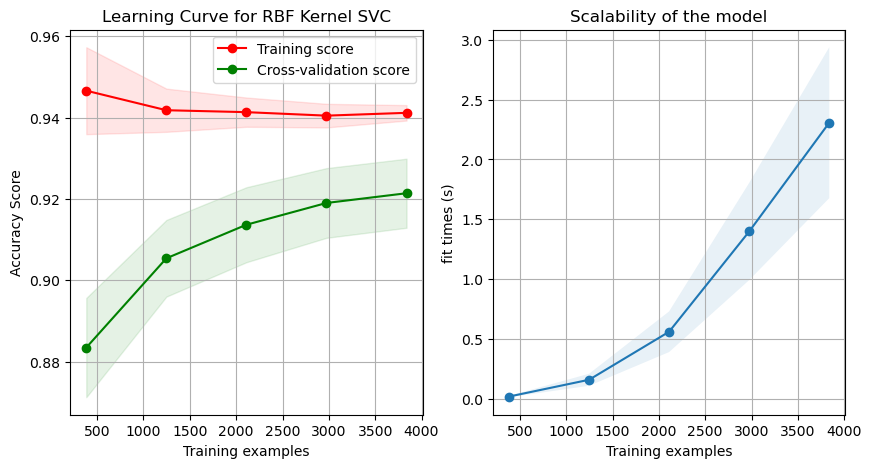

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

title = "Learning Curve for RBF Kernel SVC"

plot_learning_curve(rbf_svm, title, features_train, labels_train, axes=axes, 
                    ylim=(0.7, 1.01), cv = cv)

In [58]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [59]:
def plot_confusion_matrix(labels_test, y_pred, normalize = False, title = None):
    conf_matrix = confusion_matrix(labels_test, y_pred)
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(conf_matrix, cmap='Blues')
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    if title:
        plt.title(title)

    plt.xticks([0, 1], ['0 (Negative)', '1 (Positive)'])
    plt.yticks([0, 1], ['0 (Negative)', '1 (Positive)'])

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, round(conf_matrix[i, j], 4),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.show()


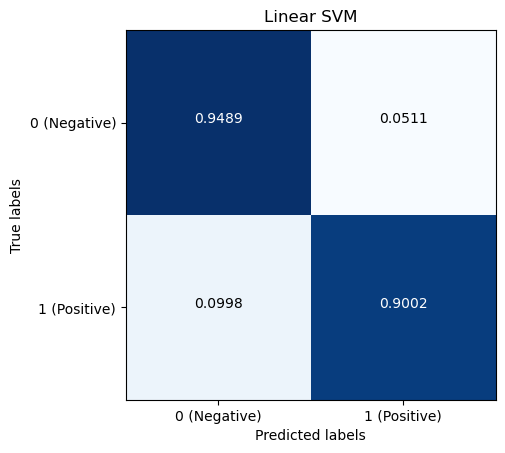

[[0.94887526 0.05112474]
 [0.0997921  0.9002079 ]]


In [60]:
plot_confusion_matrix(labels_test, y_pred_linear, normalize=True, title = 'Linear SVM')
conf_mat = confusion_matrix(labels_test, y_pred_linear)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(conf_mat)


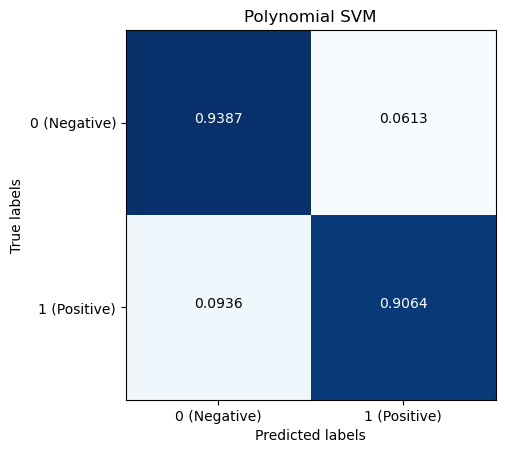

[[0.93865031 0.06134969]
 [0.09355509 0.90644491]]


In [61]:
plot_confusion_matrix(labels_test, y_pred_poly, normalize=True, title = 'Polynomial SVM')
conf_mat = confusion_matrix(labels_test, y_pred_poly)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(conf_mat)


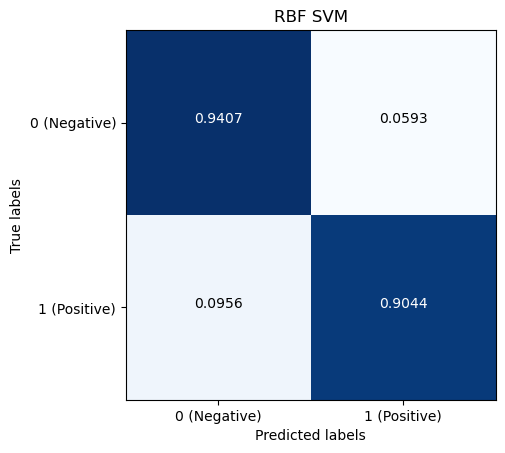

[[0.9406953 0.0593047]
 [0.0956341 0.9043659]]


In [62]:
plot_confusion_matrix(labels_test, y_pred_rbf, normalize=True, title = 'RBF SVM')
conf_mat = confusion_matrix(labels_test, y_pred_rbf)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(conf_mat)

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score

In [64]:
def plot_ROC_curve(model, features_test, labels_test, title = None):

    # predict the scores of the positive class
    y_scores = model.decision_function(features_test)

    # calculate the false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = roc_curve(labels_test, y_scores)

    # calculate the AUC
    auc = roc_auc_score(labels_test, y_scores)
    
    # plot the ROC curve
    if title:
        plt.title(title)
        
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

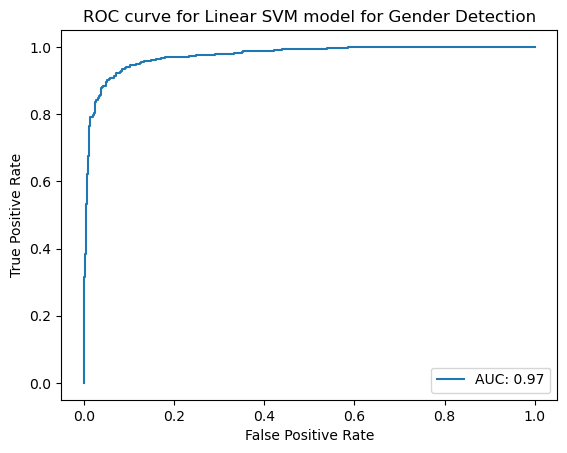

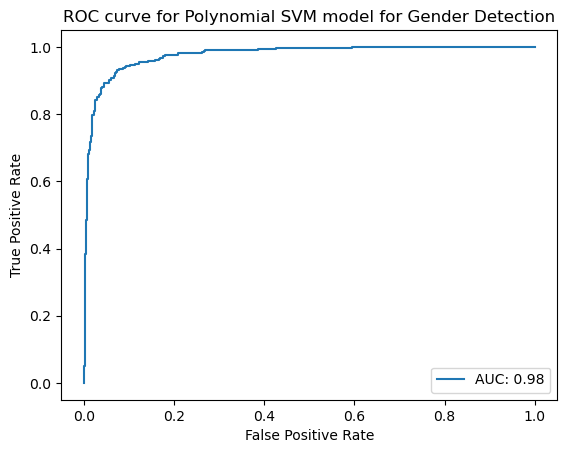

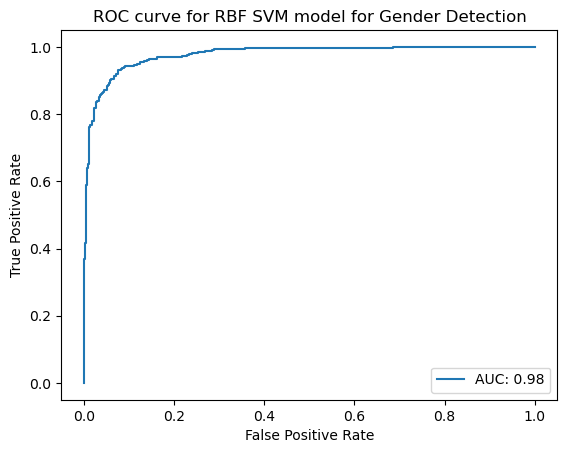

/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.p

/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.p

/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.p

/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.p

/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.p

/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zceeysa/Desktop/ENTER/lib/python3.8/site-packages/sklearn/svm/_base.p

In [65]:
plot_ROC_curve(linear_svm, features_test, labels_test, title = 'ROC curve for Linear SVM model for Gender Detection')
plot_ROC_curve(poly_svm, features_test, labels_test, title = 'ROC curve for Polynomial SVM model for Gender Detection')
plot_ROC_curve(rbf_svm, features_test, labels_test, title = 'ROC curve for RBF SVM model for Gender Detection')